In [1]:
# pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats
import scaleogram as scg 
import warnings
from itertools import product
#ARIMA And stationaru test
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima

from scipy.signal import savgol_filter
from scipy import stats
import scaleogram as scg 
import warnings
from itertools import product
warnings.filterwarnings("ignore")
save_plot = False
# choose default wavelet function for the entire notebook
scg.set_default_wavelet('gaus5')

# EDA
The data we choose is the monthly price per ton of wheat, we created a date column and perfomned the neccesary test 

In [3]:
#read example data 
df = pd.read_csv('rice_wheat_corn_prices.csv')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  360 non-null    int64  
 1   Month                 360 non-null    object 
 2   Price_wheat_ton       359 non-null    float64
 3   Price_rice_ton        360 non-null    float64
 4   Price_corn_ton        360 non-null    float64
 5   Inflation_rate        359 non-null    float64
 6   Price_wheat_ton_infl  359 non-null    float64
 7   Price_rice_ton_infl   359 non-null    float64
 8   Price_corn_ton_infl   359 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 25.4+ KB
None


date transformation

In [4]:
#make the date index
df['Date'] = np.zeros(len(df))
for i in range(len(df)):
    df['Date'][i] = '-'.join([str(df['Year'][i]),df['Month'][i],'01']) 
df['Date']= pd.to_datetime(df['Date'], format='%Y-%b-%d')

In [5]:
df = df.dropna()
df.set_index('Date',inplace = True)
print(df.head())

            Year Month  Price_wheat_ton  Price_rice_ton  Price_corn_ton  \
Date                                                                      
1992-02-01  1992   Feb           170.12          278.25          113.62   
1992-03-01  1992   Mar           161.44          277.20          117.00   
1992-04-01  1992   Apr           153.07          278.00          108.52   
1992-05-01  1992   May           139.72          274.00          109.64   
1992-06-01  1992   Jun           140.36          268.80          110.90   

            Inflation_rate  Price_wheat_ton_infl  Price_rice_ton_infl  \
Date                                                                    
1992-02-01           89.59                322.53               527.53   
1992-03-01           89.59                306.07               525.54   
1992-04-01           89.59                290.21               527.06   
1992-05-01           89.59                264.90               519.48   
1992-06-01           89.59          

In [6]:
#read data 
#df = pd.read_csv('international-airline-passengers.csv',header = 0, index_col = 0, squeeze = True)
#


# #plot
# fig,ax = plt.subplots(figsize=(8,4))
# ax.plot(data)

# ax.vlines(0,ymin =100,ymax =600,color='r',linestyles='--')
# ax.vlines(50,ymin =100,ymax =600,color='r',linestyles='--', label='30 days time frame')
# ax.hlines(data[0:50].mean(),xmin =0,xmax =50,color='k',linestyles='--',label=f"""Mean 1 = {data[0:50].mean():.1f} +/-{data[0:30].std():.1f}""")
# #
# ax.hlines(data[-50:].mean(),xmin =94,xmax =144,color='k',linestyles='--',label=f"""Mean 2 = {data[-50:].mean():.1f}+/-{data[100:130].std():.1f}""")
# ax.vlines(94,ymin =100,ymax =600,color='r',linestyles='--')
# ax.vlines(144,ymin =100,ymax =600,color='r',linestyles='--')

# ax.set_xlabel('Months',fontsize=14)

# ax.set_ylabel('Number of International Passangers',fontsize=14)
# ax.set_title('Number of International Passangers 1949-1960',fontsize=20)
# ax.legend(loc=9)
# if save_plot:
#     plt.savefig('non_stationary.pdf')
# plt.show()
#df_month = df.resample('M').mean()

## Stationarity Formal Tests

Do Augmented DickeyFuller and Kwiatkowski-Phillips-Schmidt-Shin

In [7]:
#define functions
#Augmented DickeyFuller
def adf_test(data,H0_conf):
    """
    Takes an array, and the null Hypotesis confidence.
    prints ADF statistics, p-value, and confidence intervals.
    """

    results = adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {results[0]:.2f}')
    print(f'p-value: {results[1]:.2f}')
    print('Critial Values:')
    for key, value in results[4].items():
        print(f'   {key} : {value:.2f}')

    print(f"""Result: The series is {"not " if results[1] > H0_conf else ""}stationary
""")

#Kwiatkowski-Phillips-Schmidt-Shin
def kpss_test(data,H0_conf, **kw):
    """
    Takes an array, and the null Hypotesis confidence.
    kw:{“c”, “ct”}
    “c” : The data is stationary around a constant (default).
    “ct” : The data is stationary around a trend.
    prints ADF statistics, p-value(), and confidence intervals.
    NOTE 
    The p-value of the test. The p-value is interpolated from
    Table 1 in Kwiatkowski et al. (1992), and a boundary point
    is returned if the test statistic is outside the table of
    critical values, that is, if the p-value is outside the
    interval (0.01, 0.1).

    """
    statistic, p_value, n_lags, critical_values = kpss(data,**kw)
    # Format Output
    print(f'KPSS Statistic: {statistic:.2f}')
    print(f'p-value: {p_value}')
    #print(f'num lags: {n_lags:.2f}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value:.2f}')
    print(f"""Result: The series is {"not " if p_value < H0_conf else ""}stationary
""")


In [8]:
print(adf_test(df.Price_wheat_ton,0.05))

ADF Statistic: -1.56
p-value: 0.50
Critial Values:
   1% : -3.45
   5% : -2.87
   10% : -2.57
Result: The series is not stationary

None


In [9]:
print(kpss_test(df.Price_wheat_ton,0.05))

KPSS Statistic: 1.57
p-value: 0.01
Critial Values:
   10% : 0.35
   5% : 0.46
   2.5% : 0.57
   1% : 0.74
Result: The series is not stationary

None


As seen above data is not stationary, in order to use ARIMA we need to make t as stationary as possible 
## Differencing

In [10]:
# for now we can use only the values beacase i am a bit lazy today 
data = df.Price_wheat_ton.dropna().values
def diff_func(data,n):
    return data[:-n]-data[n:]
differencing =  diff_func(data,1)#first order differenced series


In [11]:
df_test = df[-30:]
df_train=df[:-30]

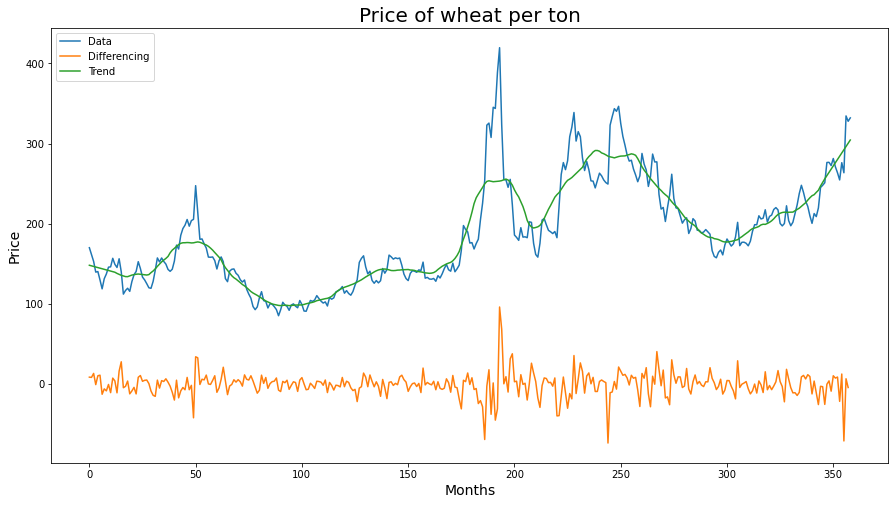

In [12]:
fig,ax = plt.subplots(figsize=(15,8))

ax.plot(data,label='Data')
ax.plot(differencing,label='Differencing')
yvalues_trend = savgol_filter(data,25,1)
ax.plot(yvalues_trend,label='Trend')
ax.set_xlabel('Months',fontsize=14)
ax.set_ylabel('Price',fontsize=14)
ax.set_title('Price of wheat per ton',fontsize=20)
ax.legend(loc=2)
if save_plot:
    plt.savefig('differencing.pdf')
plt.show()


https://www.projectpro.io/article/how-to-build-arima-model-in-python/544#:~:text=Model%20in%20Python%3F-,ARIMA%20Model%2D%20Complete%20Guide%20to%20Time%20Series%20Forecasting%20in%20Python,data%20to%20predict%20future%20values.

# ARIMA

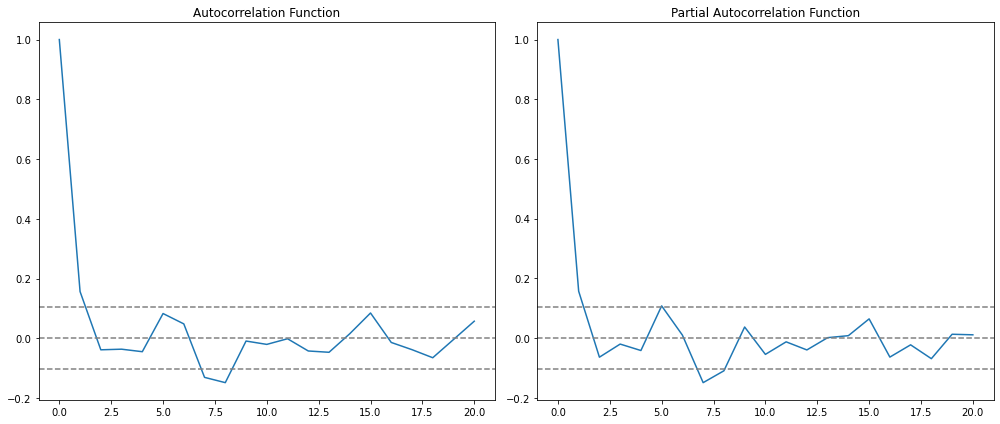

In [13]:

#I SAW THIS GRAPHS AND THEY ARE USEFULL TO STE THE ARIMA PARAMETERS, YOU USE THE X VALUE WHEN Y =0 OR SOMETHING 
#BUT THE WAY I DID IT WE DONT NEED THEM WE CAN DISCUSS IF WE KEEO THEM OR NO.....

lag_acf = acf(differencing, nlags=20)
lag_pacf = pacf(differencing, nlags=20, method='ols')


fig, ax =plt.subplots(1,2, figsize =(14,6))
#Plot ACF:
#plt.subplot(121)
ax[0].plot(lag_acf)
ax[0].axhline(y=0, linestyle='--', color='gray')
ax[0].axhline(y=-1.96/np.sqrt(len(differencing)), linestyle='--', color='gray')
ax[0].axhline(y=1.96/np.sqrt(len(differencing)), linestyle='--', color='gray')
ax[0].set_title('Autocorrelation Function')            

#Plot PACF
#plt.subplot(122)
ax[1].plot(lag_pacf)
ax[1].axhline(y=0, linestyle='--', color='gray')
ax[1].axhline(y=-1.96/np.sqrt(len(differencing)), linestyle='--', color='gray')
ax[1].axhline(y=1.96/np.sqrt(len(differencing)), linestyle='--', color='gray')
ax[1].set_title('Partial Autocorrelation Function')
plt.tight_layout()            
plt.show()

This thing gives the best parameters.....

In [14]:
stepwise_fit  =auto_arima(df.Price_wheat_ton,trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2963.797, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2968.637, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2961.744, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2960.805, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2966.953, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2962.349, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2962.361, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2961.798, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2959.041, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2960.608, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2960.620, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2959.972, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2960.055, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.749 seconds


In [15]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  359
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1477.521
Date:                Sat, 19 Mar 2022   AIC                           2959.041
Time:                        09:00:45   BIC                           2966.802
Sample:                             0   HQIC                          2962.128
                                - 359                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1730      0.031      5.633      0.000       0.113       0.233
sigma2       225.0506      7.098     31.706      0.000     211.139     238.962
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1293.24
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 720x360 with 0 Axes>

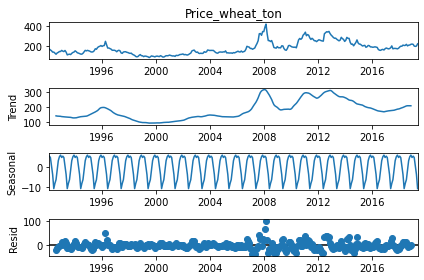

In [16]:
#FROM HERE THE METHOD STARTS 
#decomposition of seasonal residuals and trend
plt.figure(figsize=(10,5))
sm.tsa.seasonal_decompose(df_train.Price_wheat_ton).plot()
plt.show()

Dickey–Fuller test: p=0.246201


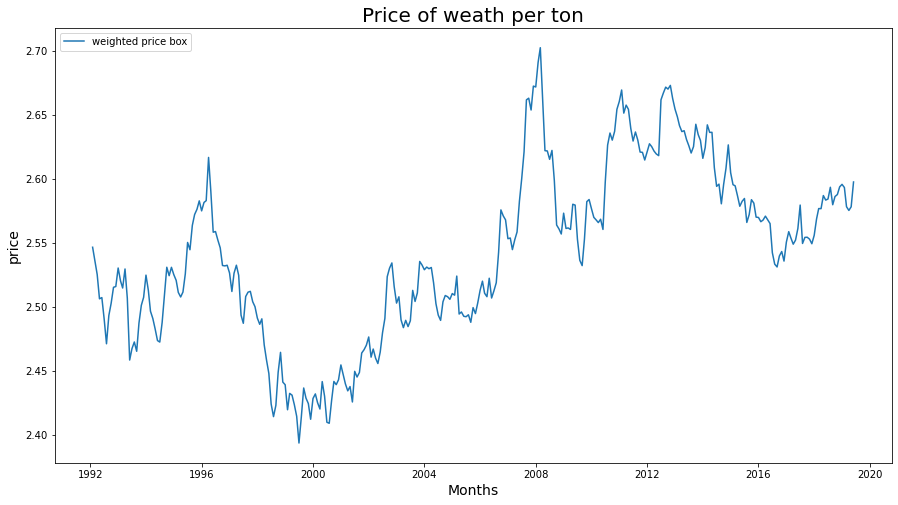

In [17]:
#here we start to decompose the data WE NEED TLO REASEARCH WHAT IS THAT BOXCOX STAT 
#IMPORTAN GIVES THIS LMBDA VALUE THAT WE NEED FOR RECOMPOSE THE THE DATA 
df_train['Weighted_Price_box'], lmbda = stats.boxcox(df_train.Price_wheat_ton)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Weighted_Price_box)[1])


fig,ax = plt.subplots(figsize=(15,8))

ax.plot(df_train.Weighted_Price_box,label='weighted price box')
ax.set_xlabel('Months',fontsize=14)
ax.set_ylabel('price',fontsize=14)
ax.set_title('Price of weath per ton',fontsize=20)
ax.legend(loc=2)
if save_plot:
    plt.savefig('weightbox.pdf')
plt.show()


Dickey–Fuller test: p=0.022191


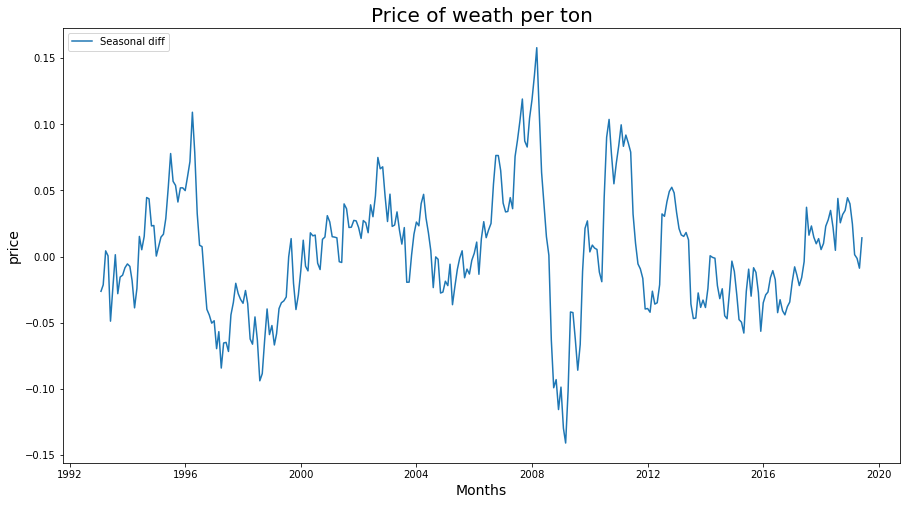

In [18]:
# Seasonal differentiation
df_train['prices_box_diff'] = df_train.Weighted_Price_box - df_train.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.prices_box_diff[12:])[1])

fig,ax = plt.subplots(figsize=(15,8))

#ax.plot(df_train.Weighted_Price_box,label='weighted price box')
ax.plot(df_train.prices_box_diff,label='Seasonal diff')
ax.set_xlabel('Months',fontsize=14)
ax.set_ylabel('price',fontsize=14)
ax.set_title('Price of weath per ton',fontsize=20)
ax.legend(loc=2)
if save_plot:
    plt.savefig('weightbox.pdf')
plt.show()


Dickey–Fuller test: p=0.000000


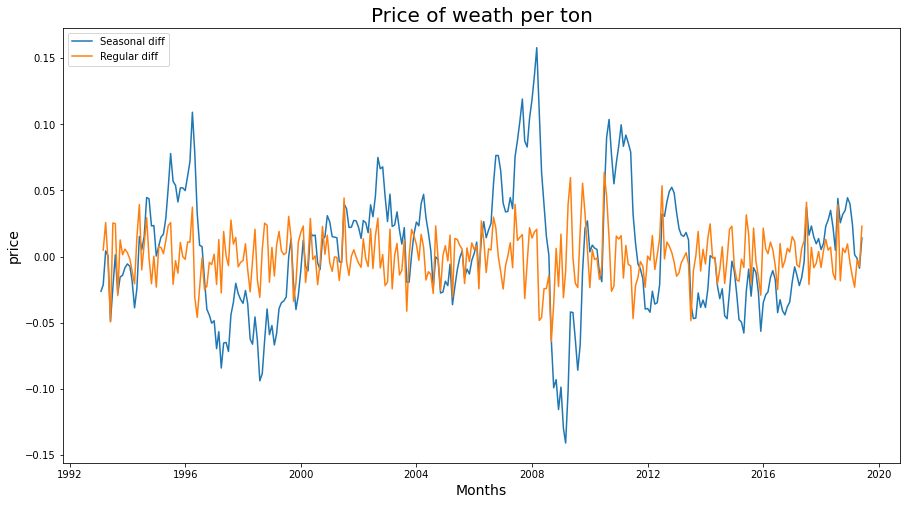

In [19]:
# Regular differentiation
df_train['prices_box_diff2'] = df_train.prices_box_diff - df_train.prices_box_diff.shift(1)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.prices_box_diff2[13:])[1])

fig,ax = plt.subplots(figsize=(15,8))

ax.plot(df_train.prices_box_diff,label='Seasonal diff')
ax.plot(df_train.prices_box_diff2,label='Regular diff')
ax.set_xlabel('Months',fontsize=14)
ax.set_ylabel('price',fontsize=14)
ax.set_title('Price of weath per ton',fontsize=20)
ax.legend(loc=2)
if save_plot:
    plt.savefig('weightbox.pdf')
plt.show()

# plt.figure(figsize=(15,7))
# # STL-decomposition
# sm.tsa.seasonal_decompose(df_train.prices_box_diff2[13:]).plot()   


# plt.show()

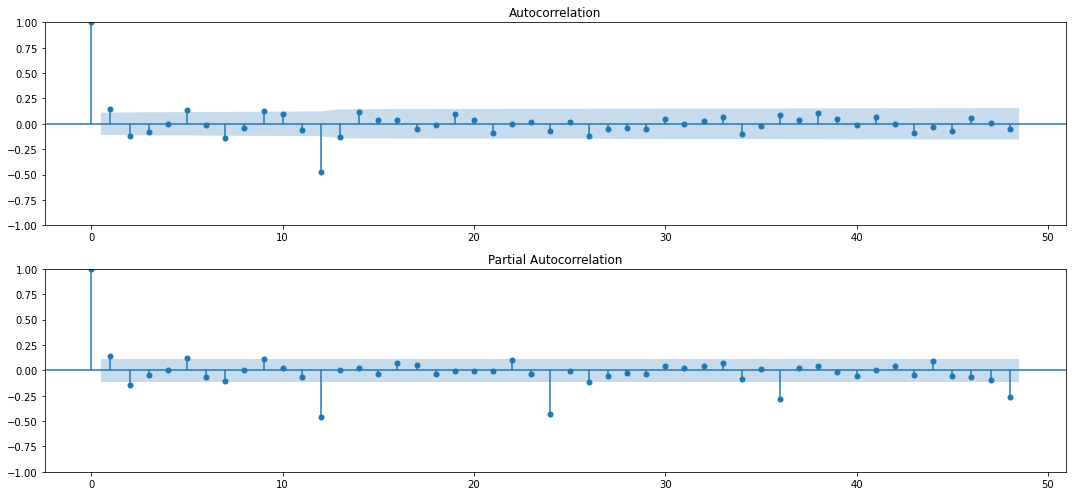

In [20]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots same shit as above we dont
#need it but look smart
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_train.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_train.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

# Read this 
https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8#:~:text=What%20is%20SARIMAX%3F,%2Daverage%20term%20(MA).

# Sarimax 
Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors, or SARIMAX, is an extension of the ARIMA class of models. Intuitively, ARIMA models compose 2 parts: the autoregressive term (AR) and the moving-average term (MA). The former views the value at one time just as a weighted sum of past values. The latter model that same value also as a weighted sum but of past residuals (confer. time series decomposition). There is also an integrated term (I) to difference the time series (we will discuss this further below). Since this is such a rich topic with a lot of math involved, we strongly recommend you to do further readings to have a better understanding.
Overall, ARIMA is a very decent type of models. However, the problem with this vanilla version is that it cannot handle seasonality — a big weakness. Comes SARIMA — the predecessor of SARIMAX.One shorthand notation for SARIMA models is:<br>
SARIMA(p,d,q)X(P,D,Q,S)
<br>
where p = non-seasonal autoregressive (AR) order, d = non-seasonal differencing, q= non-seasonal moving average (MA) order, P = seasonal AR order, D = seasonal differencing, Q = seasonal MA order, and S = length of repeating seasonal pattern. We will use this notation from now on. By adding those seasonal AR and seasonal MA components, SARIMA solves the seasonality problem.
SARIMAX extends on this framework just by adding the capability to handle exogenous variables. Holidays is the go-to option, but you can also get your own domain-specific features if you need to. 
Lags are simply delays in time steps within a series. Consider a time index t, the lag 1 time index with respect to t is simply t-1, lag 2 is t-2, and so on.

I guess we can use the df_train.prices_box_diff2 as well and try the ARIMA intseatd on SARIMAX.... it was easier with SARIMAX

In [21]:
#this finds the paramters using SARIMAX on the weigted price box 
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [22]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())


      parameters          aic
17  (0, 2, 2, 1) -1802.878927
41  (2, 0, 2, 1) -1802.590950
11  (0, 1, 2, 1) -1801.970972
29  (1, 1, 2, 1) -1801.725769
37  (2, 0, 0, 1) -1801.385785
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  329
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 907.439
Date:                              Sat, 19 Mar 2022   AIC                          -1802.879
Time:                                      09:02:47   BIC                          -1780.344
Sample:                                  02-01-1992   HQIC                         -1793.877
                                       - 06-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

Dickey–Fuller test:: p=0.000000


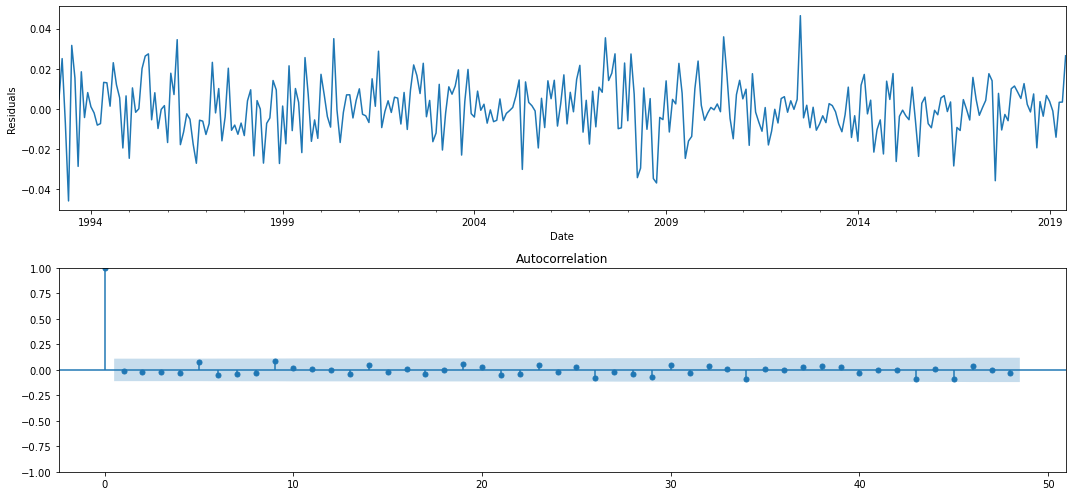

In [23]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [24]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
start = len(df_train)
end = len(df_train) + len(df_test) - 1
#make predivtions in test set 
pred = invboxcox(best_model.predict(start=start, end=end), lmbda)
#join preds with last 1 values of testing for ploting 
pred.index = df.index[start:end+1]
df_pred = pd.concat([df.Price_wheat_ton[-31:-30].to_frame(),pred.to_frame(name="Price_wheat_ton")])

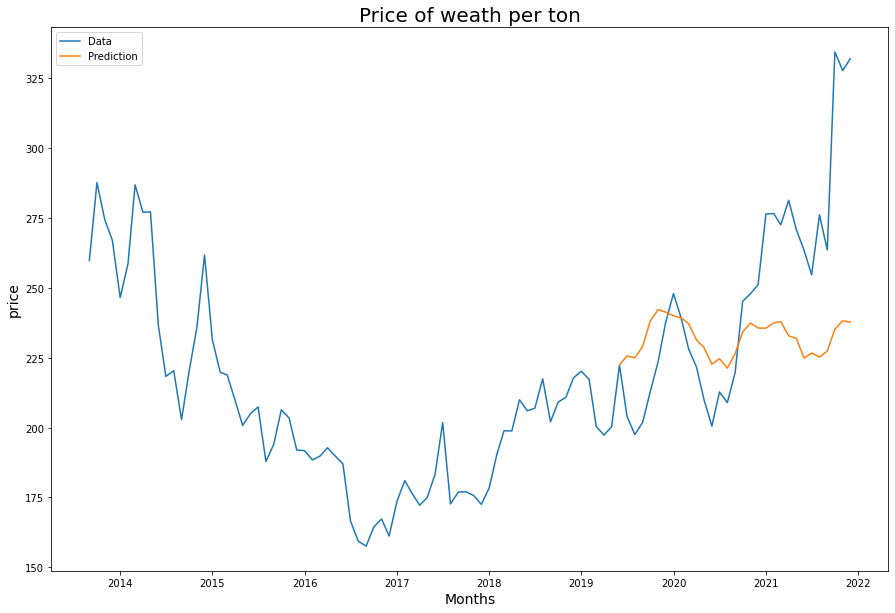

In [25]:
fig,ax = plt.subplots(figsize = (15,10))
ax.plot(df.Price_wheat_ton[-100:],label = 'Data')
ax.plot(df_pred.Price_wheat_ton,label = 'Prediction')
ax.set_xlabel('Months',fontsize=14)
ax.set_ylabel('price',fontsize=14)
ax.set_title('Price of weath per ton',fontsize=20)
ax.legend(loc=2)

plt.show()


In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,df.Price_wheat_ton[-30:]))
rmse, df.Price_wheat_ton.mean()

(39.198390222822105, 185.30286908078006)

# Time-frequency domain decomposition

In [27]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [28]:
time = np.linspace(1, len(data),len(data))
signal = data


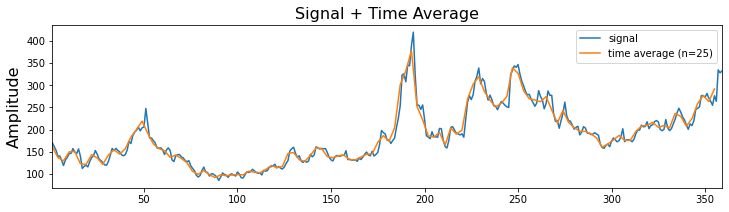

In [29]:
def get_ave_values(xvalues, yvalues, n = 25):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 25):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(25))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

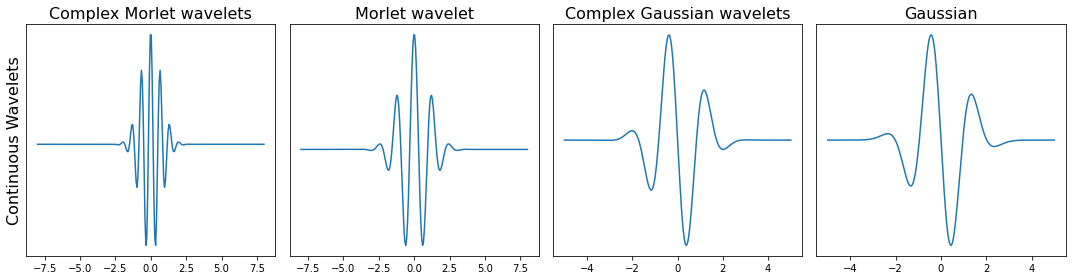

In [30]:
#the wavelet transform was performed using this wavlets
waves  = ['cmor1-1.5', 'morl', 'cgau5', 'gaus5']
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
for i, wavelet in enumerate(waves):
    wavelet_plot = pywt.ContinuousWavelet(wavelet)
    family_name = wavelet_plot.family_name
    biorthogonal = wavelet_plot.biorthogonal
    orthogonal = wavelet_plot.orthogonal
    symmetry = wavelet_plot.symmetry
    if i == 0:
        _ = wavelet_plot.wavefun()
        wavelet_function = _[0]
        x_values = _[-1]
    else:
        wavelet_function, x_values = wavelet_plot.wavefun()

    if i == 0:
        ax[i].set_ylabel("Continuous Wavelets", fontsize=16)
    ax[i].set_title("{}".format(family_name), fontsize=16)
    ax[i].plot(x_values, wavelet_function)
    ax[i].set_yticks([])
    ax[i].set_yticklabels([])

plt.tight_layout()
plt.savefig('wavelets.pdf')
plt.show()

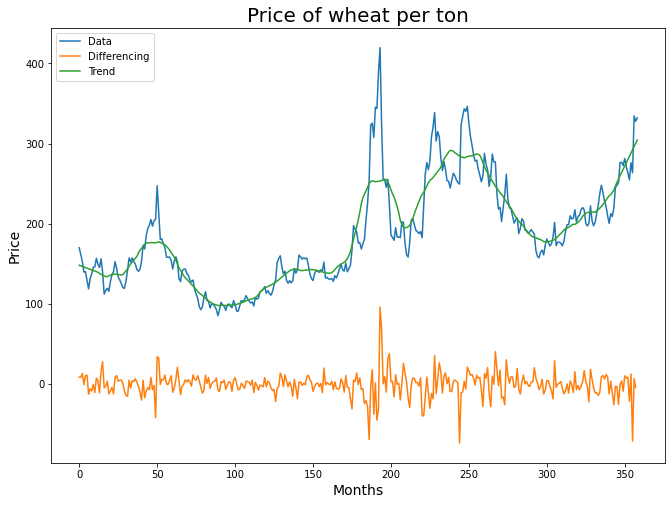

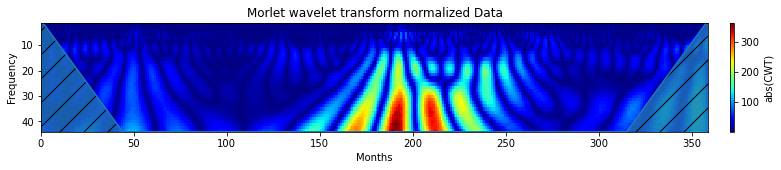

In [31]:

scg.set_default_wavelet(waves[1])
#normalize the data 
data_norm = data -data.mean()
fig,ax = plt.subplots(figsize=(11,8))

ax.plot(data,label='Data')
ax.plot(differencing,label='Differencing')
yvalues_trend = savgol_filter(data,25,1)
ax.plot(yvalues_trend,label='Trend')
ax.set_xlabel('Months',fontsize=14)
ax.set_ylabel('Price',fontsize=14)
ax.set_title('Price of wheat per ton',fontsize=20)
ax.legend(loc=2)
if save_plot:
    plt.savefig('differencing.pdf')


coikw = {'alpha': .8, 'hatch': '/'} #error in scg fix thanks bulgarian guy from the internet

#ax = scg.cws(data, figsize=(13, 2),coikw=coikw, xlabel=" ", ylabel="Frequency", title='Morlet wavelet transform')
ax = scg.cws(data_norm, figsize=(13, 2),coikw=coikw, xlabel="Months", ylabel="Frequency",title='Morlet wavelet transform normalized Data')

plt.savefig('wavelets_final3.pdf')
plt.show()

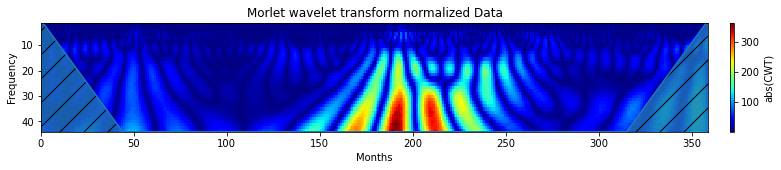

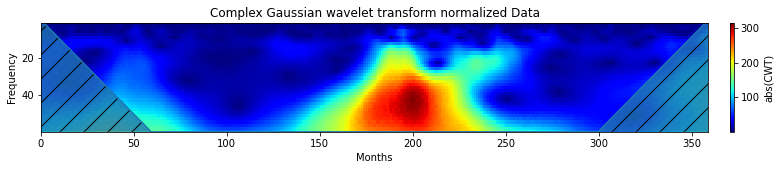

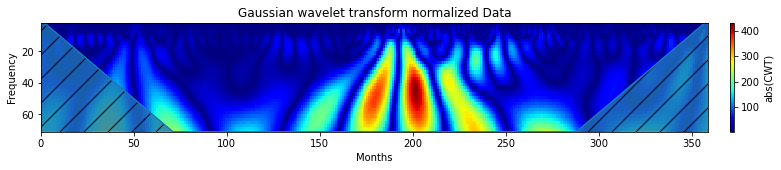

In [32]:
scg.set_default_wavelet(waves[1])
ax = scg.cws(data_norm, figsize=(13, 2),coikw=coikw, xlabel="Months", ylabel="Frequency",title='Morlet wavelet transform normalized Data')

scg.set_default_wavelet(waves[2])
ax = scg.cws(data_norm, figsize=(13, 2),coikw=coikw, xlabel="Months", ylabel="Frequency",title='Complex Gaussian wavelet transform normalized Data')

scg.set_default_wavelet(waves[3])
ax = scg.cws(data_norm, figsize=(13, 2),coikw=coikw, xlabel="Months", ylabel="Frequency",title='Gaussian wavelet transform normalized Data')


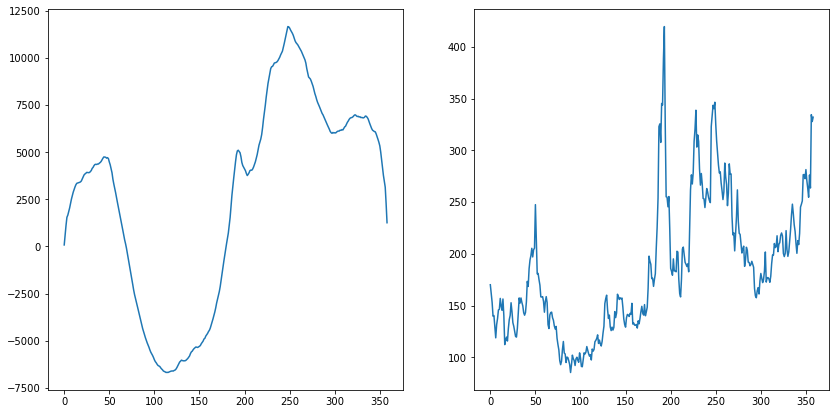

In [33]:
scales = np.arange(1, len(data))
coefficients, frequencies = pywt.cwt(signal, scales, 'morl', 1)
mwf = pywt.ContinuousWavelet('morl').wavefun()
y_0 = mwf[0][np.argmin(np.abs(mwf[1]))]

r_sum = np.transpose(np.sum(np.transpose(coefficients)/ scales ** 0.5, axis=-1))

reconstructed = r_sum * (1 / y_0)
fig,ax = plt.subplots(1,2, figsize =(14,7))
ax[0].plot(reconstructed)
ax[1].plot(data)
plt.show()

In [34]:
kpss_test(coefficients[1],0.05)

KPSS Statistic: 0.06
p-value: 0.1
Critial Values:
   10% : 0.35
   5% : 0.46
   2.5% : 0.57
   1% : 0.74
Result: The series is stationary

